*Filename* : BatchNorm  
*Test Accuracy* : (73.24%%)  
*Train Accuracy* : (71.82%)  
*Total params* : 45,472

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [2]:
%cd '/content/gdrive/MyDrive/ERA2/session8/'
import model

/content/gdrive/MyDrive/ERA2/session8


In [10]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [5]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
# Mean and STD calculation
data = train.data / 255 # data is numpy array

mean = data.mean(axis = (0,1,2))
std = data.std(axis = (0,1,2))
print(f"Mean : {mean}   STD: {std}") #Mean : [0.491 0.482 0.446]   STD: [0.247 0.243 0.261]

Mean : [0.49139968 0.48215841 0.44653091]   STD: [0.24703223 0.24348513 0.26158784]


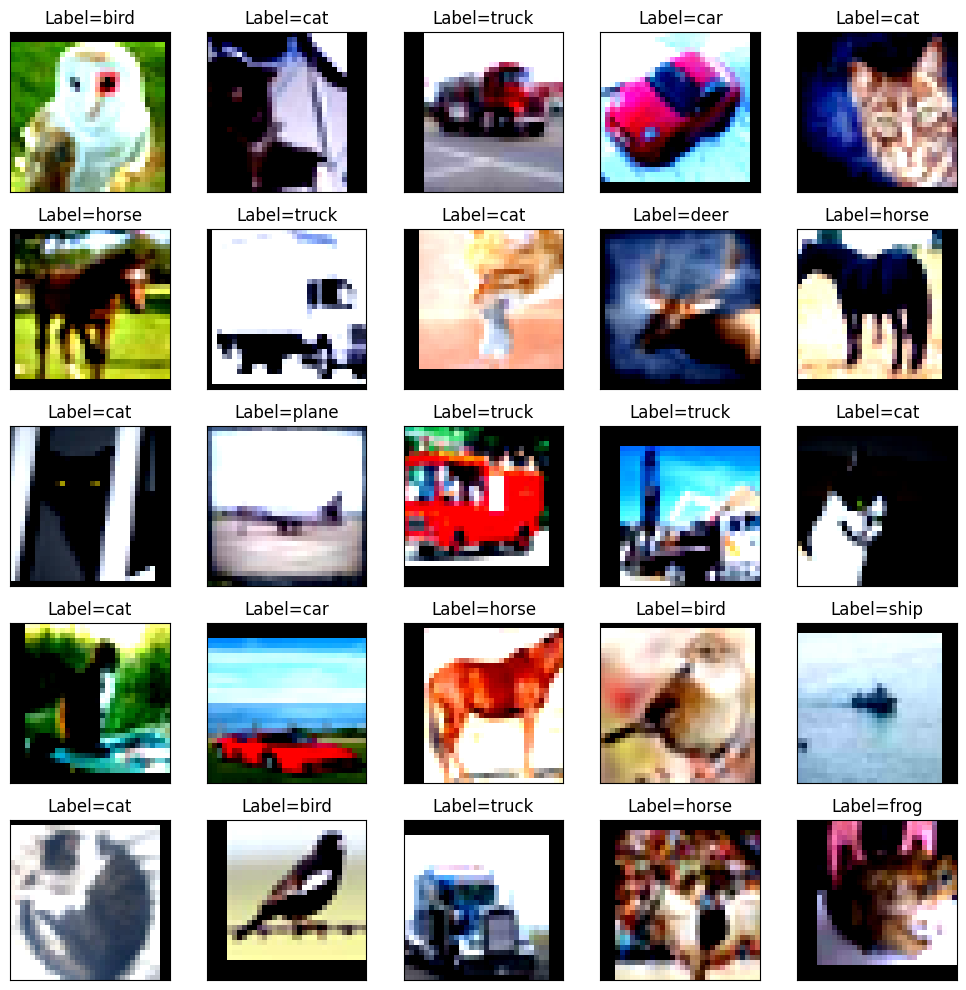

In [11]:
# get some random training images
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
images,labels = next(iter(train_loader))

sample_size=25

images = images[0:sample_size]
labels = labels[0:sample_size]

fig = plt.figure(figsize=(10, 10))

# Show images
for idx in np.arange(len(labels.numpy())):
    ax = fig.add_subplot(5, 5, idx+1, xticks=[], yticks=[])
    # npimg = unnormalize(images[idx])
    # ax.imshow(images[idx], cmap='gray')
    img = images[idx]/2 + 0.5
    img = np.clip(img, 0, 1)
    img = np.transpose(img, (1,2,0))
    plt.imshow(img, cmap='gray', interpolation='none')
    ax.set_title("Label={}".format(str(classes[labels[idx]])))

fig.tight_layout()
plt.show()

In [12]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model_S8_BN = model.Model_S8_BN().to(device)
summary(model_S8_BN, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             432
              ReLU-2           [-1, 16, 30, 30]               0
       BatchNorm2d-3           [-1, 16, 30, 30]              32
           Dropout-4           [-1, 16, 30, 30]               0
            Conv2d-5           [-1, 20, 30, 30]           2,880
              ReLU-6           [-1, 20, 30, 30]               0
       BatchNorm2d-7           [-1, 20, 30, 30]              40
           Dropout-8           [-1, 20, 30, 30]               0
            Conv2d-9           [-1, 10, 30, 30]             200
        MaxPool2d-10           [-1, 10, 15, 15]               0
           Conv2d-11           [-1, 16, 13, 13]           1,440
             ReLU-12           [-1, 16, 13, 13]               0
      BatchNorm2d-13           [-1, 16, 13, 13]              32
          Dropout-14           [-1

In [13]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [14]:
from torch.optim.lr_scheduler import StepLR

model_S8_BN =  model.Model_S8_BN().to(device)
optimizer = optim.SGD(model_S8_BN.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=9, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model_S8_BN, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model_S8_BN, device, test_loader)

EPOCH: 0


Loss=1.290200114250183 Batch_id=390 Accuracy=38.43: 100%|██████████| 391/391 [00:24<00:00, 16.08it/s]



Test set: Average loss: 1.4324, Accuracy: 4878/10000 (48.78%)

EPOCH: 1


Loss=1.179387092590332 Batch_id=390 Accuracy=52.37: 100%|██████████| 391/391 [00:28<00:00, 13.51it/s]



Test set: Average loss: 1.2339, Accuracy: 5558/10000 (55.58%)

EPOCH: 2


Loss=0.9214059114456177 Batch_id=390 Accuracy=57.33: 100%|██████████| 391/391 [00:24<00:00, 15.84it/s]



Test set: Average loss: 1.2219, Accuracy: 5699/10000 (56.99%)

EPOCH: 3


Loss=0.96148282289505 Batch_id=390 Accuracy=60.31: 100%|██████████| 391/391 [00:24<00:00, 15.82it/s]



Test set: Average loss: 1.0855, Accuracy: 6139/10000 (61.39%)

EPOCH: 4


Loss=0.9825453758239746 Batch_id=390 Accuracy=62.31: 100%|██████████| 391/391 [00:25<00:00, 15.31it/s]



Test set: Average loss: 0.9780, Accuracy: 6529/10000 (65.29%)

EPOCH: 5


Loss=0.9356743097305298 Batch_id=390 Accuracy=64.43: 100%|██████████| 391/391 [00:25<00:00, 15.31it/s]



Test set: Average loss: 0.9954, Accuracy: 6477/10000 (64.77%)

EPOCH: 6


Loss=1.091383934020996 Batch_id=390 Accuracy=65.61: 100%|██████████| 391/391 [00:26<00:00, 14.89it/s]



Test set: Average loss: 0.9279, Accuracy: 6747/10000 (67.47%)

EPOCH: 7


Loss=0.9079025983810425 Batch_id=390 Accuracy=66.34: 100%|██████████| 391/391 [00:25<00:00, 15.24it/s]



Test set: Average loss: 0.9119, Accuracy: 6823/10000 (68.23%)

EPOCH: 8


Loss=0.8665499687194824 Batch_id=390 Accuracy=67.50: 100%|██████████| 391/391 [00:24<00:00, 16.00it/s]



Test set: Average loss: 0.8530, Accuracy: 7024/10000 (70.24%)

EPOCH: 9


Loss=0.8783162236213684 Batch_id=390 Accuracy=69.92: 100%|██████████| 391/391 [00:23<00:00, 16.41it/s]



Test set: Average loss: 0.7913, Accuracy: 7214/10000 (72.14%)

EPOCH: 10


Loss=0.8241466283798218 Batch_id=390 Accuracy=70.76: 100%|██████████| 391/391 [00:23<00:00, 16.78it/s]



Test set: Average loss: 0.7884, Accuracy: 7224/10000 (72.24%)

EPOCH: 11


Loss=0.7170388698577881 Batch_id=390 Accuracy=70.36: 100%|██████████| 391/391 [00:23<00:00, 16.65it/s]



Test set: Average loss: 0.7840, Accuracy: 7235/10000 (72.35%)

EPOCH: 12


Loss=0.9038122892379761 Batch_id=390 Accuracy=70.96: 100%|██████████| 391/391 [00:23<00:00, 16.47it/s]



Test set: Average loss: 0.8049, Accuracy: 7163/10000 (71.63%)

EPOCH: 13


Loss=0.92035973072052 Batch_id=390 Accuracy=70.90: 100%|██████████| 391/391 [00:24<00:00, 16.01it/s]



Test set: Average loss: 0.7761, Accuracy: 7281/10000 (72.81%)

EPOCH: 14


Loss=0.8833032846450806 Batch_id=390 Accuracy=71.20: 100%|██████████| 391/391 [00:24<00:00, 15.73it/s]



Test set: Average loss: 0.7833, Accuracy: 7282/10000 (72.82%)

EPOCH: 15


Loss=0.8569097518920898 Batch_id=390 Accuracy=71.20: 100%|██████████| 391/391 [00:24<00:00, 15.74it/s]



Test set: Average loss: 0.7762, Accuracy: 7271/10000 (72.71%)

EPOCH: 16


Loss=0.9010480046272278 Batch_id=390 Accuracy=71.46: 100%|██████████| 391/391 [00:24<00:00, 15.83it/s]



Test set: Average loss: 0.7655, Accuracy: 7298/10000 (72.98%)

EPOCH: 17


Loss=0.7545822858810425 Batch_id=390 Accuracy=71.42: 100%|██████████| 391/391 [00:23<00:00, 16.44it/s]



Test set: Average loss: 0.7793, Accuracy: 7266/10000 (72.66%)

EPOCH: 18


Loss=0.864495575428009 Batch_id=390 Accuracy=71.76: 100%|██████████| 391/391 [00:23<00:00, 16.84it/s]



Test set: Average loss: 0.7632, Accuracy: 7326/10000 (73.26%)

EPOCH: 19


Loss=0.5822139978408813 Batch_id=390 Accuracy=71.82: 100%|██████████| 391/391 [00:22<00:00, 17.00it/s]



Test set: Average loss: 0.7696, Accuracy: 7324/10000 (73.24%)



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


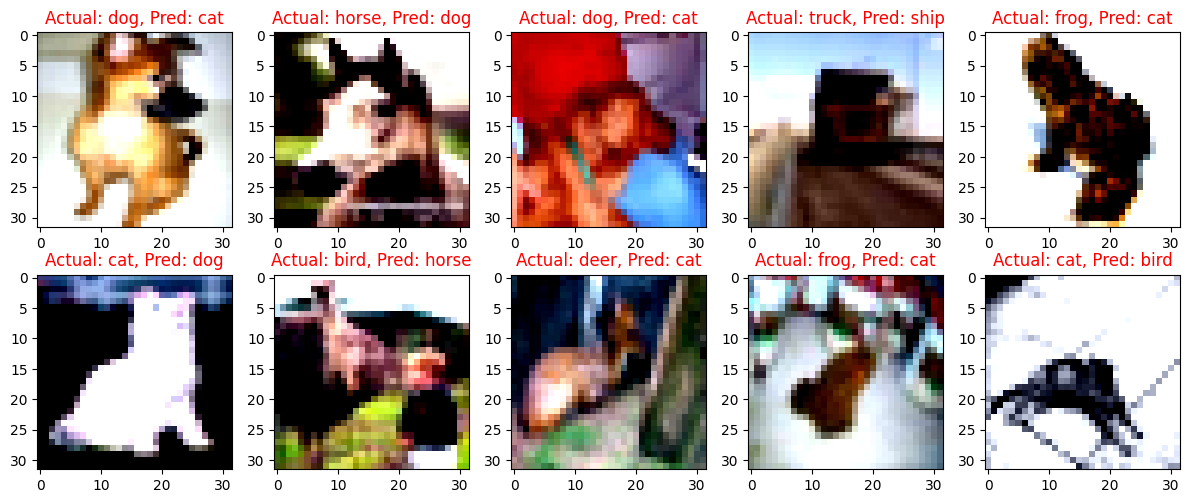

In [16]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
model_S8_BN.eval()

misclassified_images = []
actual_labels = []
predicted_labels = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model_S8_BN(data)
        _, pred = torch.max(output, 1)
        for i in range(len(pred)):
            if pred[i] != target[i]:
                misclassified_images.append(data[i])
                actual_labels.append(classes[target[i]])
                predicted_labels.append(classes[pred[i]])

# Plot the misclassified images
fig = plt.figure(figsize=(12, 5))
for i in range(10):
    sub = fig.add_subplot(2, 5, i+1)
    img = misclassified_images[i].cpu()
    img = img/2 + 0.5
    img = np.clip(img, 0, 1)
    img = np.transpose(img, (1,2,0))
    plt.imshow(img, cmap='gray', interpolation='none')
    sub.set_title("Actual: {}, Pred: {}".format(actual_labels[i], predicted_labels[i]),color='red')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Test Accuracy')

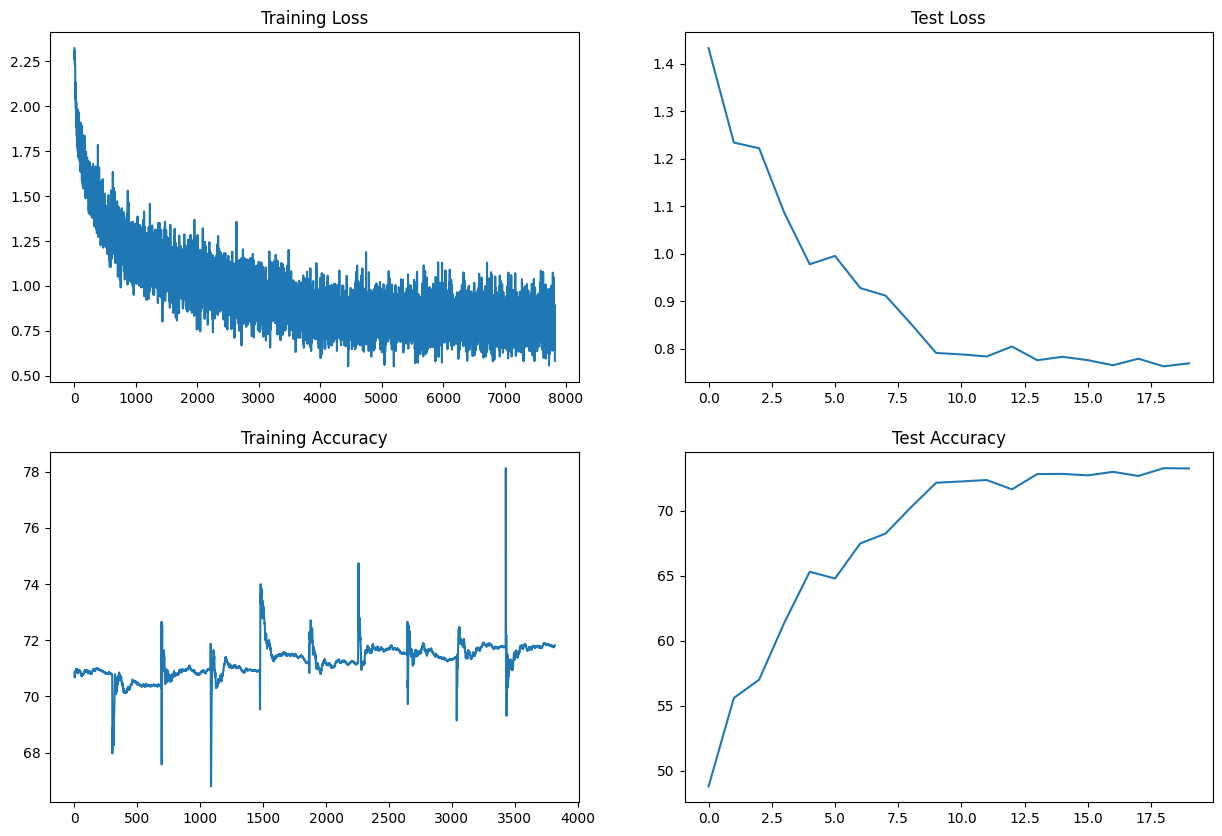

In [17]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")